In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fault = pd.read_table("data/d09_te.dat", sep="\s+",header=None)
norm = pd.read_table("data/d00_te.dat", sep="\s+",header=None)

In [3]:
# %%writefile fault_detector.py
# import numpy as np
# import pandas as pd
# from scipy import stats
# from sklearn.decomposition import PCA


# class FaultDetector:
#     """
#     Needed to be imported Numpy and Pandas
#     Class to perform fault detection over dataset of time-series data with few variables
    
#     Initialization with:
#     data_norm - 'matrix', dataset with normal behavior of process
#     data_fault - 'matrix', dataset for fault detection
#     type_PCA - 'string', type of analysis. Can be neither PCA or DPCA, default = PCA
#     L - 'int' number of lags for DPCA, usually calculation can be done automatically, default = None
#     rolling - 'bool', enable rolling window over dataset, default = False
#     window - 'int', size of rolling window, default = 10
#     random_seed - 'int', seed to reproduce result, default = 2022
    
#     Methods:
#     self.hotelling_statistic - return T2 row of statistics
#     self.hotelling_treshold(alpha) - return treshold for T2 statistic with alpha (level of significance)
#     self.q_statistic - return Q2 row statistics
#     self.q_treshold(alpha) - return treshold for Q2 statistic with alpha (level of significance)
#     self.augmentation(L, data) - return dataset with L lags in data
    
    
#     Calculations based on:
#     [1] Evan L. Russell, Leo H. Chiang, Richard D. Braatz, Fault detection in industrial processes using canonical
#     variate analysis and dynamic principal component analysis, 2000, https://doi.org/10.1016/S0169-7439(00)00058-7.
#     [2] Wenfu Ku, Robert H. Storer, Christos Georgakis, Disturbance detection and isolation by dynamic principal
#     component analysis, 1995, https://doi.org/10.1016/0169-7439(95)00076-3.
#     """

#     def __init__(self, data_norm, data_fault, type_PCA='PCA', L=None, rolling=False, window=10, random_seed=2022):
#         # Defence from other methods
#         self.mode = ['PCA', 'DPCA']
#         assert type_PCA in self.mode, 'Mode must be neither PCA or DPCA'
#         self.type_pca = type_PCA
        
#         # Store data inside of class
#         self.norm = data_norm.copy()
#         self.fault = data_fault.copy()
        
#         # If Rolling is True, then use rolling average window 
#         if rolling:
#             self.norm = self.norm.rolling(window=window, center=False).mean().dropna(axis=0)
#             self.fault = self.fault.rolling(window=window, center=False).mean().dropna(axis=0)

#         # Store mean and std of normal data variables
#         self.mean = self.norm.mean(axis=0)
#         self.std = self.norm.std(axis=0)
        
#         # Fix seed
#         np.random.seed(random_seed)
        
#         # Data can come in numpy array or pandas DataFrame
#         # Normalize normal dataset
#         if isinstance(self.norm, pd.DataFrame):
#             self.data0 = ((self.norm - self.mean) / self.std).to_numpy()
#         else:
#             self.data0 = ((self.norm - self.mean) / self.std)
#         # Normalize fault dataset
#         if isinstance(self.fault, pd.DataFrame):
#             self.data1 = ((self.fault - self.mean) / self.std).to_numpy()
#         else:
#             self.data1 = ((self.fault - self.mean) / self.std)
        
#         # Make augmentation over datasets if type_pca is 'DPCA'
#         if self.type_pca == 'DPCA':
#             # If L needed to be specified manually
#             if L:
#                 self.L = L
#                 self.data1 = self.augmentation(self.L, self.data1.copy())
#             else:
#                 self.L, self.data1 = self._lags_num()  # Receive number of lags and augmented fault dataset
#             self.data0 = self.augmentation(self.L, self.data0.copy())  # Receive augmented normal dataset
            
#         self.n = self.data1.shape[0]  # Number of observations
#         self.a = self._get_a_number()  # Receive new number of dimensions for PCA decomposition

#     def _get_a_number(self):
#         """
#         Calculate new number of dimensions for PCA decomposition based on parallel analysis.
#         """
#         # Almost independent observations is simulated by random gaussian noise
#         noise = np.random.normal(size=self.data1.shape)
#         _, s_noise, _ = np.linalg.svd(noise)  # SVD decomposition
#         _, s_fault, _ = np.linalg.svd(self.data1)  # SVD decomposition
#         a = np.argmin(abs(s_fault - s_noise)) + 1  # Find crossing point on the plot of singular values
#         return a

#     def hotelling_statistic(self):
#         """
#         Calculation of hotelling (T2) statistic, based on the work [1]
#         """
#         pca = PCA(self.a)  # Initialization of PCA decomposition
#         pca.fit(self.data1/np.sqrt(self.n-1))  # Find principal components
#         s = np.diag(pca.singular_values_)  # Get truncated matrix of singular values
#         sig2 = np.linalg.inv(s).dot(np.linalg.inv(s))
#         P = pca.components_.T  # Get principal components

#         time_series_statistic = []  # Basket
#         for i in range(self.n):
#             x = self.data1[i, :]
#             stat = x.T.dot(P).dot(sig2).dot(P.T).dot(x)
#             time_series_statistic.append(stat)  # Add data into the basket
            
#         return time_series_statistic

#     def hotelling_treshold(self, alpha):
#         """
#         Calculation threshold of T2 staticstic based on the Fisher distribution
#         """
#         mult = (((self.n**2) - 1) * self.a) / (self.n * (self.n - self.a))
#         crit_val = stats.f.ppf(q=1-alpha/2, dfn=self.a, dfd=self.n-self.a)  # Critical value for F distribution

#         return mult * crit_val

#     def q_statistic(self):
#         """
#         Calculation Q2 statistic (Residuals) for fault dataset based on theory in [1]
#         """
#         pca = PCA(self.a)  # Initialization of PCA decomposition
#         pca.fit(self.data0)  # Find principal components
#         P0 = pca.components_.T  # Get principal components

#         T4 = self.data1.dot(P0)  # Project data to normal principal components

#         Q = self.data1 - T4.dot(P0.T)
#         Q = Q.T                     # Calculation statistic
#         Q = np.sum(Q**2, axis=0)
#         return Q
    
#     def q_treshold(self, alpha):
#         """
#         Calculation threshold of Q2 statistic
#         """
#         _, s, _ = np.linalg.svd(self.data1/np.sqrt(self.n-1))

#         th1 = np.sum(s[self.a+1:]**2)
#         th2 = np.sum(s[self.a+1:]**4)
#         th3 = np.sum(s[self.a+1:]**6)
#         h0 = 1 - (2*th1*th3)/(3*th2**2)

#         ca = stats.norm.ppf(1-alpha)

#         q = th1 * ((h0*ca*np.sqrt(2*th2))/th1 + 1 + (th2*h0*(h0-1))/th1**2)**(1/h0)
#         return q

#     def _lags_num(self):
#         """
#         Calculation of appropriate number of lags based on algorithm proposed in [2]
#         L - number of lags
#         r - rank of matrix
#         """
        
#         r_new = np.zeros(10)
#         # Step 1
#         L = 1
#         while True:

#             # Step 2
#             augmented = self.augmentation(L, self.data1.copy())

#             # Step 3
#             _, s_fault, _ = np.linalg.svd(augmented)

#             # Step 4
#             j = self.data1.shape[1]*L-1
#             r = 0

#             # Step 5 and 6, choose threshold 0.01
#             while s_fault[j] < 0.01:
#                 j = j - 1
#                 r = r + 1

#             # Step 7
#             summa = 0
#             for i in range(L):
#                 summa += (L-i+1)*r_new[i] 
#             r_new[L] = r - summa

#             # Step 8
#             if r_new[L] <= 0:
#                 break

#             # Step 9
#             L = L + 1
#         return L, augmented

#     def augmentation(self, L, data):
#         """
#         Create a lagged dataframe with number of lag L over Data
#         L - 'int', Number of lags
#         data - 'np.array', dataset
#         """
#         augmented = []  # Basket
#         for t in range(data.shape[0]-L+1):
#             aux = data[t:t+L, :].ravel()  # One row in new dataset
#             augmented.append(aux)  # Add row into the basket
#         augmented = np.array(augmented)  # Convert also to np.array
#         return augmented


In [4]:
from fault_detector import FaultDetector

In [5]:
detector_pca = FaultDetector(data_norm = norm, data_fault = fault, type_PCA = 'PCA')

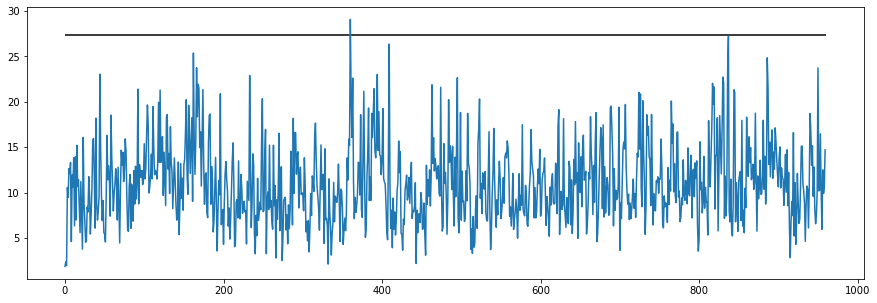

In [6]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
t_stat = detector_pca.hotelling_statistic()
plt.plot(np.arange(0, len(t_stat)), t_stat)
plt.hlines(detector_pca.hotelling_treshold(0.01), 0, len(t_stat))

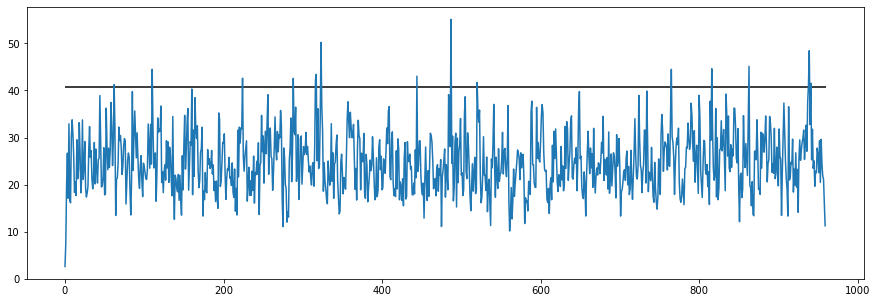

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
q_stat = detector_pca.q_statistic()
plt.plot(np.arange(0, len(q_stat)), q_stat)
plt.hlines(detector_pca.q_treshold(0.005), 0, len(q_stat))

In [8]:
detector_dpca = FaultDetector(norm, fault, 'DPCA', False)

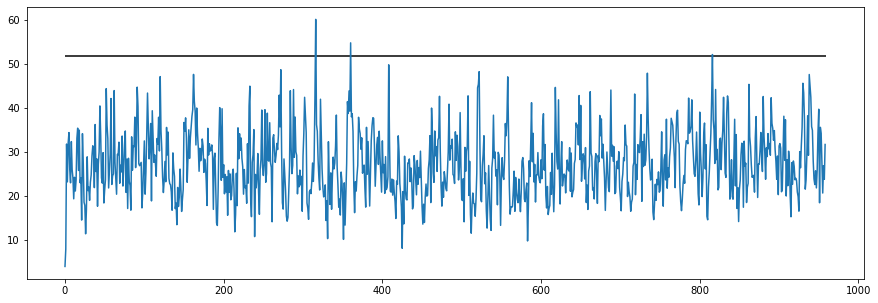

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
t_stat = detector_dpca.hotelling_statistic()
plt.plot(np.arange(0, len(t_stat)), t_stat)
plt.hlines(detector_dpca.hotelling_treshold(0.01), 0, len(t_stat))

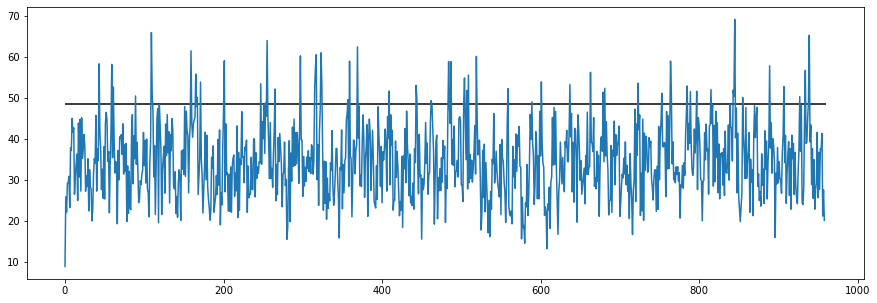

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
q_stat = detector_dpca.q_statistic()
plt.plot(np.arange(0, len(q_stat)), q_stat)
plt.hlines(detector_dpca.q_treshold(0.005), 0, 960)

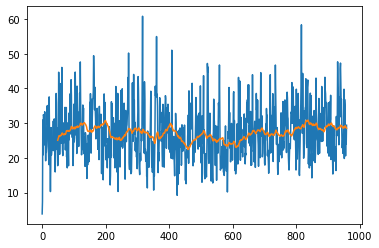

In [11]:
t_stat = detector_dpca.hotelling_statistic()
rol_avg = pd.Series(t_stat).rolling(window=50).mean()
plt.plot(np.arange(0, len(t_stat)), t_stat)
plt.plot(np.arange(0, len(rol_avg)), rol_avg)

In [12]:
# %%writefile app.py
# import streamlit as st
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# from fault_detector import FaultDetector
# import os


# def main():
#     """
#     Main function for streamlit app
#     :return:
#     """

#     st.title('Fault detection algorithm')
#     files = os.listdir('data')
#     st.sidebar.title('file choose')

#     normal_dataset_name = st.sidebar.selectbox('Choose dataset with process normal behavior',
#                                                files,
#                                                key='normal_dataset_name')
#     fault_dataset_name = st.sidebar.selectbox('Choose dataset with fault', files, key='fault_dataset_name')
#     type_pca = st.sidebar.radio('Preferable type of PCA analysis', ['PCA', 'DPCA'], key='type_pca')
#     isExtended = st.sidebar.checkbox('Enable additional settings')
    
#     if isExtended:
#         L = st.sidebar.slider('Lags number', min_value=1, max_value=50, step=1, key='L')
#         a = st.sidebar.slider('Target decomposition dimensions', min_value=1, max_value=52, step=1, key='a')
#         isRolling = st.sidebar.checkbox('Rolling window on dataset')
#         if isRolling:
#             window_data = st.sidebar.number_input('Window size', min_value=1, max_value=100, step=1,
#                                                   key='window_data_size')
#         else:
#             window_data = 10
#     else:
#         L = None
#         isRolling = False
#         window_data = 10

#     norm, fault = load_data(normal_dataset_name, fault_dataset_name)
    
#     detector = FaultDetector(data_norm=norm,
#                              data_fault=fault,
#                              type_PCA=type_pca,
#                              L=L,
#                              rolling=isRolling,
#                              window=window_data)
#     if isExtended:
#         detector.a = a
    
#     print_plots(fault)
    
#     print_means_std(detector)
    
#     st.text(f'Current dimensionality a is {detector.a}')
#     if type_pca == 'DPCA':
#         st.text(f'Current chosen number of lag L is {detector.L}')
        
#     print_statistics(detector)
    
    
# def load_data(normal_dataset_name, fault_dataset_name):
#     """
#     Upload chosen datafiles
#     :param normal_dataset_name:  file name for normal data
#     :param fault_dataset_name:  file name for data with fault
#     :return: norm, fault - pandas DataFrame
#     """
#     norm = pd.read_table(f"data/{normal_dataset_name}", sep='\s+', header=None)
#     fault = pd.read_table(f"data/{fault_dataset_name}", sep='\s+', header=None)
#     return norm, fault


# def print_plots(data):
#     """
#     Plot original time series data
#     :param data: pd.DataFrame, dataset to plot
#     :return: None
#     """
#     fig = px.line(data, x=data.index, y=data.columns, title='Original time series with fault',
#                   template='simple_white')
#     fig.update_layout(height=500, width=1000, showlegend=True, xaxis_title="Time point (each 3 min)",
#                       yaxis_title="Parameter", legend_title="Variables")
#     st.plotly_chart(figure_or_data=fig, use_container_width=False)    
#     return


# def print_means_std(detector):
#     """
#     Print plots with mean and std values for scaled fault dataset
#     :param detector: class FaultDetector
#     :return: None
#     """
#     # Mean and std for normalized fault data
#     means = pd.DataFrame(detector.data1.mean(axis=0))
#     std_div = pd.DataFrame(detector.data1.std(axis=0))
    
#     fig = make_subplots(rows=1, cols=2,
#                         subplot_titles=("Mean values for normalized fault data",
#                                         "Std values for normalized fault data"),
#                         x_title='Variable number',
#                         y_title='Value')
    
#     fig.add_trace(go.Bar(x=means.index, y=means[0], name='Mean values', ), row=1, col=1)
#     fig.add_trace(go.Bar(x=std_div.index, y=std_div[0], name='Std values'), row=1, col=2)
#     fig.update_layout(height=400, width=1000, showlegend=True, template='simple_white')
#     st.plotly_chart(figure_or_data=fig, use_container_width=False)
#     return


# def print_statistics(detector):
#     """
#     Plot statistics via methods hotelling_statistic and q_statistic
#     :param detector: class FaultDetector
#     :return: None
#     """
#     t_stat = detector.hotelling_statistic()
#     q_stat = detector.q_statistic()

#     isRollingWindow = st.checkbox('Enable rolling window')
    
#     if isRollingWindow:
#         window = st.number_input('Window size', min_value=1, max_value=100, step=1, key='window_size')
#         rol_avg_t = pd.Series(t_stat).rolling(window=window).mean()
#         rol_avg_q = pd.Series(q_stat).rolling(window=window).mean()

#     fig = make_subplots(rows=1, cols=2,
#                         subplot_titles=("T2 statistic for fault data", "Q2 statistic for fault data"),
#                         x_title="Time point (each 3 min)",
#                         y_title='Value')
    
#     fig.add_trace(go.Scatter(x=np.arange(len(t_stat)), y=t_stat, mode='lines', name='T2'), row=1, col=1)
#     fig.add_trace(go.Scatter(x=np.arange(len(q_stat)), y=q_stat, mode='lines', name='Q2'), row=1, col=2)
#     if isRollingWindow:
#         fig.add_trace(go.Scatter(x=np.arange(len(rol_avg_t)), y=rol_avg_t, mode='lines', name='MA of T2'), row=1, col=1)
#         fig.add_trace(go.Scatter(x=np.arange(len(rol_avg_q)), y=rol_avg_q, mode='lines', name='MA of Q2'), row=1, col=2)
    
#     fig.update_layout(height=400, width=1000, showlegend=True, template='simple_white')
#     st.plotly_chart(figure_or_data=fig, use_container_width=False)


# if __name__ == '__main__':
#     main()


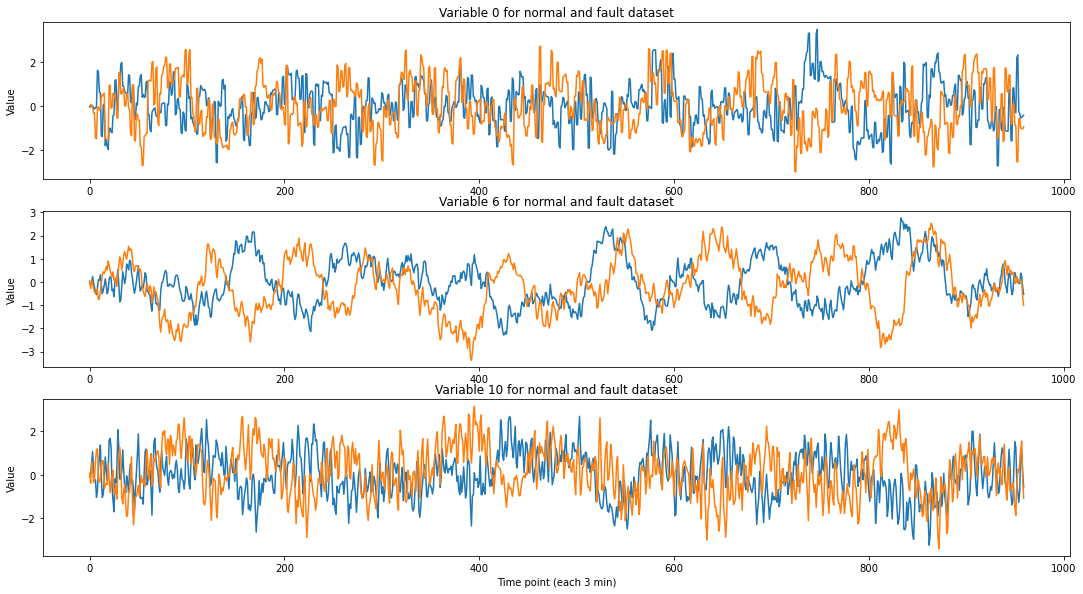

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(15,8))
fig.tight_layout()
ax[0].plot(np.arange(0, 960), detector_pca.data0[:,0])
ax[0].plot(np.arange(0, 960), detector_pca.data1[:,0])
ax[0].set_title('Variable 0 for normal and fault dataset')
ax[0].set_ylabel('Value')

ax[1].plot(np.arange(0, 960), detector_pca.data0[:,6])
ax[1].plot(np.arange(0, 960), detector_pca.data1[:,6])
ax[1].set_title('Variable 6 for normal and fault dataset')
ax[1].set_ylabel('Value')

ax[2].plot(np.arange(0, 960), detector_pca.data0[:,10])
ax[2].plot(np.arange(0, 960), detector_pca.data1[:,10])
ax[2].set_title('Variable 10 for normal and fault dataset')
ax[2].set_ylabel('Value')
ax[2].set_xlabel('Time point (each 3 min)')
None

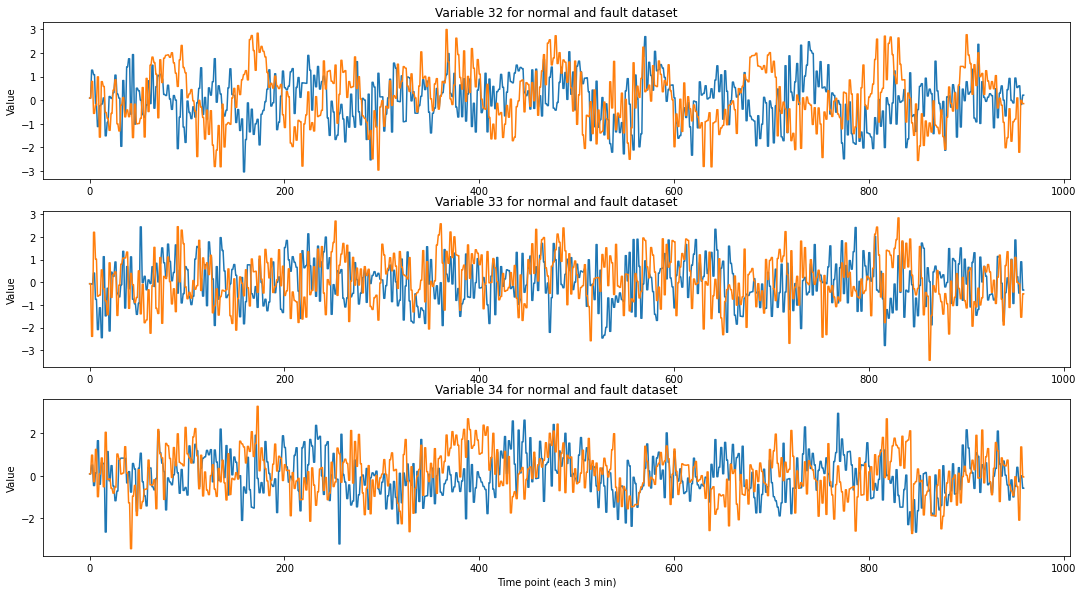

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(15,8))
fig.tight_layout()
ax[0].plot(np.arange(0, 960), detector_pca.data0[:,32])
ax[0].plot(np.arange(0, 960), detector_pca.data1[:,32])
ax[0].set_title('Variable 32 for normal and fault dataset')
ax[0].set_ylabel('Value')

ax[1].plot(np.arange(0, 960), detector_pca.data0[:,33])
ax[1].plot(np.arange(0, 960), detector_pca.data1[:,33])
ax[1].set_title('Variable 33 for normal and fault dataset')
ax[1].set_ylabel('Value')

ax[2].plot(np.arange(0, 960), detector_pca.data0[:,34])
ax[2].plot(np.arange(0, 960), detector_pca.data1[:,34])
ax[2].set_title('Variable 34 for normal and fault dataset')
ax[2].set_ylabel('Value')
ax[2].set_xlabel('Time point (each 3 min)')
None